In [17]:
from rdkit import Chem
from rdkit.Chem import QED, RDConfig, Descriptors, DataStructs, AllChem

import pandas as pd
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import plotly.graph_objects as go

import networkx as nx

In [2]:
#dataset from https://github.com/wengong-jin/iclr19-graph2graph/tree/master
df_qed = pd.read_csv('/Users/jihyeonje/Desktop/data/qed/train_pairs.txt', header=None, sep=' ') #sim coef 0.4, qed from [0.7,0.8] to [0.9,1.0]
df_plogp = pd.read_csv('/Users/jihyeonje/Desktop/data/logp04/train_pairs.txt', header=None, sep=' ') #sim coef 0.4 

In [3]:
smi = df_qed[0][10]
mol = Chem.MolFromSmiles(smi)

#start processing 3D coordinates
updated_mol= Chem.AddHs(mol)
AllChem.EmbedMolecule(updated_mol)
AllChem.UFFOptimizeMolecule(updated_mol)
updated_mol.GetConformer()

#to get atom type, coordinate, edges
mblock = Chem.MolToMolBlock(updated_mol)
print(mblock)


     RDKit          3D

 47 49  0  0  0  0  0  0  0  0999 V2000
   -5.6686   -1.5782    0.5171 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.2729   -1.2484   -0.0317 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.2224   -1.4862   -1.5518 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.8208    0.1776    0.3937 C   0  0  2  0  0  0  0  0  0  0  0  0
   -4.7142    1.2276   -0.1176 N   0  0  0  0  0  0  0  0  0  0  0  0
   -4.6984    2.5614    0.4101 C   0  0  0  0  0  0  0  0  0  0  0  0
   -5.5853    3.5478   -0.1154 N   0  0  0  0  0  0  0  0  0  0  0  0
   -3.9038    2.8716    1.3383 O   0  0  0  0  0  0  0  0  0  0  0  0
   -2.3957    0.4387   -0.0293 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.1631    1.0991   -1.0790 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3123   -0.0778    0.7596 N   0  0  0  0  0  0  0  0  0  0  0  0
    0.0514   -0.1384    0.3102 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.3706   -0.4037   -1.0495 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.7116   -0.4847   -1

In [4]:
parsed = mblock.split("\n")
stats = parsed[3]
tot_atoms = int(stats.split(" ")[1])
tot_edges = int(stats.split(" ")[2])

coors = parsed[4:tot_atoms+4]
edges = parsed[tot_atoms+4:tot_atoms+tot_edges+4]


In [5]:
edge_dict = []
for i in range(tot_edges):
    edge_inf = [int(x) for x in edges[i].split()[0:3]]
    edge_dict.append({(edge_inf[0], edge_inf[1]):edge_inf[2]})

In [6]:
node_dict = []
for j in range(tot_atoms):
    atom_type = coors[j][:-37][-1]
    xyz_coor = [float(x) for x in coors[j][:-37][:-2].split()]
    node_dict.append({'node': j+1, 'x': xyz_coor[0], 'y': xyz_coor[1], 'z': xyz_coor[2], 'type': atom_type})

In [7]:
N = len(node_dict)
N

47

In [8]:
import igraph as ig

In [9]:
color_map = {'C': 'goldenrod',
             'O': 'aqua',
             'N': 'magenta',
             'S': 'darkmagenta',
             'H': 'green'} 

In [10]:
node_num=[]
color_code=[]
atom_type=[]

Xn = []
Yn = []
Zn = []
for node in node_dict:
    node_num.append(node['node'])
    atom_type.append(node['type'])
    color_code.append(color_map[node['type']])

    Xn.append(node['x'])
    Yn.append(node['y'])
    Zn.append(node['z'])

In [11]:
edges = [[*edge_dict[k]][0] for k in range(len(edge_dict))]

In [12]:
x_edges = []
y_edges = []
z_edges = []
bond_type = []
#need to fill these with all of the coordiates
for i in range(len(edge_dict)):
    #format: [beginning,ending,None]
    edge, bond = next(iter(edge_dict[i].items()))
    x_coords = [Xn[edge[0]-1],Xn[edge[1]-1],None]
    x_edges += x_coords

    y_coords = [Yn[edge[0]-1],Yn[edge[1]-1],None]
    y_edges += y_coords

    z_coords = [Zn[edge[0]-1],Zn[edge[1]-1],None]
    z_edges += z_coords
    bond_type.append(bond)

In [18]:
trace_edges = go.Scatter3d(x=x_edges,
                        y=y_edges,
                        z=z_edges,
                        mode='lines',
                        line=dict(color='black', width=2),
                        hoverinfo='none'
)

In [19]:
#create a trace for the nodes
trace_nodes = go.Scatter3d(x=Xn,
                         y=Yn,
                        z=Zn,
                        mode='markers',
                        marker=dict(symbol='circle',
                                    size=10,
                                    color=color_code,
                                    line=dict(color='black', width=0.5)),
                        text=atom_type,
                        hoverinfo='text')

In [20]:
#we need to set the axis for the plot 
axis = dict(showbackground=False,
            showline=True,
            zeroline=False,
            showgrid=True,
            showticklabels=False,
            title='')

In [21]:
#also need to create the layout for our plot
layout = go.Layout(
                width=650,
                height=625,
                showlegend=False,
                scene=dict(xaxis=dict(axis),
                        yaxis=dict(axis),
                        zaxis=dict(axis),
                        ),
                margin=dict(t=100),
                hovermode='closest')

In [22]:

#Include the traces we want to plot and create a figure
data = [trace_edges, trace_nodes]
fig = go.Figure(data=data, layout=layout)

fig.show()

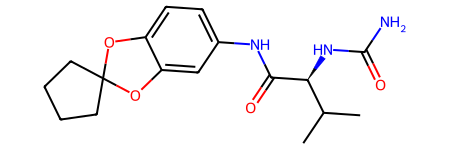

In [ ]:
mol